# **Real Time Image Processing**

#### This project reading frame by frame from camera and create 7 kinds of masks and diplay them on screen

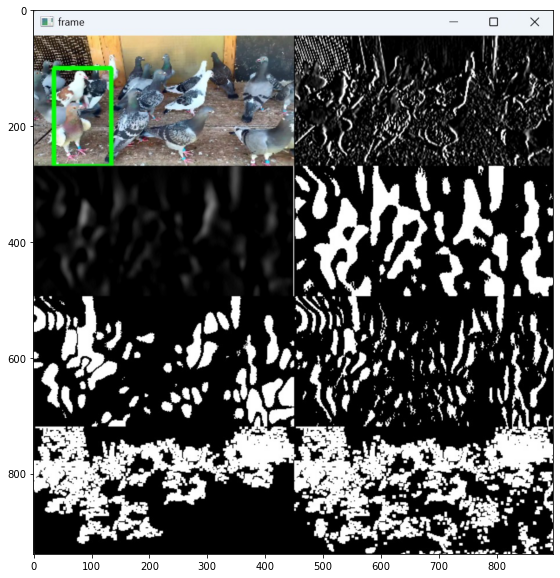

In [19]:
import matplotlib.pyplot as plt

image = plt.imread(r'C:\')
plt.subplots(figsize=(15,10))
plt.imshow(image)

### Import Libraries, Loading model and Camera  ###

In [1]:
import os
import cv2
import numpy as np
import cvlib as cv
import tensorflow as tf
import matplotlib.pyplot as plt

from cvlib.object_detection import draw_bbox

# This path is for loading video to detection
video_path = (r'C:\') 

# This path is loaction for the saved images 
outPutPath = (r'C:\') 

### Define Application Constans and Variables

In [2]:
# Initializes variables
high, width = None, None

# save sequence of 5 frames
index = []
capture = []
frame_counter = 0
frameSequence = 5

# Catch frame from webcam
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()

# Create backgroung of the main frame
foregroundModel = cv2.createBackgroundSubtractorMOG2()

# Create gray frame from camera
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (25, 25), 0)

# Initializes last frame variable and resize it
last_frame = gray
last_frame = cv2.resize(last_frame, dsize=(300, 150))

# Sobel filter to detect vertical changes on image
f1 = np.array([[1, 0, -1],
               [2, 0, -2],
               [1, 0, -1]])

# Initializing Conv2D layer for GRAY input
layer = tf.keras.layers.Conv2D(filters=1,
                               kernel_size=(3, 3),
                               strides=1,
                               padding='same',
                               activation='relu',
                               input_shape=(high, width, 1),
                               use_bias=False,
                               kernel_initializer=tf.keras.initializers.constant(f1))

### Define The Application Functions ###

In [3]:
# This function remove the components that are smaller than praticular threshold
def keepLargeComponents(image, treshold):
    
    frame = np.zeros(image.shape) < 0 # boolean array
    unique_labels = np.unique(image.flatten()) # find out every unique value that is actually a label 
    
    for label in unique_labels:
        if label == 0: # background
            pass
        else:
            img = (image == label) # save the component
            if treshold < np.sum(img):
                frame = frame | img # save all the components
                
    return np.float32(255*frame)


# This function save sequence on the disk
def saveSequence(caputre, frame_counter, frameSequence, outPutPath):
    
    treshold = frameSequence
    
    if len(caputre) < treshold:
        pass
    else:
        counter = 1
        for frame in caputre:
            image_name = str(frame_counter)+'_'+ str(counter)+'.jpg'
            finalPath = os.path.join(outPutPath, image_name)
            bbox, labels, conf = cv.detect_common_objects(frame)
            frame = draw_bbox(frame, bbox, labels, conf)
            cv2.imwrite(finalPath, frame)
            
            counter += 1

### Define number of masks for different kind of tasks ###
Masks using to recognize movements in frames and detect object 

In [4]:
# Function create a mask with Sobel filter to detect vertical changes on image
def mask1(frame_bgr, foreground_mask):

    # Slicing from tuple only first two elements
    (high, width) = frame_bgr.shape[:2]

    # Converting captured frame to GRAY by OpenCV function    
    frame_gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    
    # Reshaping frame to (batch size, rows, columns, channels)
    input_frame = frame_gray.reshape(1, high, width, 1).astype(np.float32)
    
    # Passing GRAY input to the Conv2D layer and to find contours later
    mask = layer(input_frame)
    
    # Converting output feature map from Tensor to Numpy array
    mask_frame = np.array(mask[0, :, :, 0])

    # Using 'clip' function to exclude values that are less than 0 and more than 255
    mask_frame = np.clip(mask_frame, 0, 255).astype(np.uint8) 
    
    # Create a matrix of frame and foreground mask
    frame_mask = np.zeros(frame_bgr.shape, np.uint8)
    
    frame_mask[:,:,0] = mask_frame
    frame_mask[:,:,1] = mask_frame
    frame_mask[:,:,2] = mask_frame
        
    return frame_mask

# Function create a mask with Sobel filter and GaussianBlur
def mask2(frame_bgr, foreground_mask):

    # Slicing from tuple only first two elements
    (high, width) = frame_bgr.shape[:2]

    # Converting captured frame to GRAY by OpenCV function    
    frame_gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    
    # Create one more frame with Gaussian blur
    frame_gray = cv2.GaussianBlur(frame_gray, (25, 25), 0)  
    
    # Reshaping frame to (batch size, rows, columns, channels)
    input_frame = frame_gray.reshape(1, high, width, 1).astype(np.float32)
    
    # Passing GRAY input to the Conv2D layer and to find contours later
    mask = layer(input_frame)
    
    # Converting output feature map from Tensor to Numpy array
    mask_frame = np.array(mask[0, :, :, 0])

    # Using 'clip' function to exclude values that are less than 0 and more than 255
    mask_frame = np.clip(mask_frame, 0, 255).astype(np.uint8) 
    
    # Create a matrix of frame and foreground mask
    frame_mask = np.zeros(frame_bgr.shape, np.uint8)
    
    frame_mask[:,:,0] = mask_frame
    frame_mask[:,:,1] = mask_frame
    frame_mask[:,:,2] = mask_frame
        
    return frame_mask

# Function create a mask with Sobel filter and Treshold
def mask3(frame_bgr, foreground_mask):
    
    # Slicing from tuple only first two elements
    (high, width) = frame_bgr.shape[:2]

    # Converting captured frame to GRAY by OpenCV function    
    gray_frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    
    # Create one more frame with Gaussian blur
    gray_frame = cv2.GaussianBlur(gray_frame, (25, 25), 0)  
    
    # Reshaping frame to (batch size, rows, columns, channels)
    gray_frame = gray_frame.reshape(1, high, width, 1).astype(np.float32)

    # Passing GRAY input to the Conv2D layer and to find contours later    
    gray_mask = layer(gray_frame)
    
    # Converting output feature map from Tensor to Numpy array
    gray_mask = np.array(gray_mask[0, :, :, 0])

    # Using 'clip' function to exclude values that are less than 0 and more than 255
    gray_mask = np.clip(gray_mask, 0, 255).astype(np.uint8)  
    
    # Function exclude values that ara more than treshhold = 15 0 and more than 255
    _, gray_mask = cv2.threshold(gray_mask, 5, 255, cv2.THRESH_BINARY)
    
    # Create a matrix of frame and foreground mask
    frame_mask = np.zeros(frame_bgr.shape, np.uint8)
    
    frame_mask[:,:,0] = gray_mask
    frame_mask[:,:,1] = gray_mask
    frame_mask[:,:,2] = gray_mask

    return frame_mask

# Function create a mask with and Treshold
def mask4(frame_bgr, last_frame):
      
    # Slicing from tuple only first two elements
    (high, width) = frame_bgr.shape[:2]

    # Converting captured frame to GRAY by OpenCV function        
    frame_gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    
    # Create one more frame with Gaussian blur
    frame_gray = cv2.GaussianBlur(frame_gray, (25, 25), 0)  
    
    abs_diff = cv2.absdiff(last_frame, frame_gray)
    
    # Function exclude values that ara more than treshhold = 15 0 and more than 255
    _, gray_mask = cv2.threshold(abs_diff, 5, 255, cv2.THRESH_BINARY)
    
    # Create a matrix of frame and foreground mask
    frame_mask = np.zeros(frame_bgr.shape, np.uint8)
    
    frame_mask[:,:,0] = gray_mask
    frame_mask[:,:,1] = gray_mask
    frame_mask[:,:,2] = gray_mask
    
    return frame_mask

# Function create a mask with Sobel filter and Treshold
def mask5(frame_bgr, last_frame):
      
    # Slicing from tuple only first two elements
    (high, width) = frame_bgr.shape[:2]
    
    # Converting captured frame to GRAY by OpenCV function            
    frame_gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    
    # Create one more frame with Gaussian blur
    frame_gray = cv2.GaussianBlur(frame_gray, (25, 25), 0)  
    
    abs_diff = cv2.absdiff(last_frame, frame_gray)

    # Reshaping frame to (batch size, rows, columns, channels)    
    gray_frame = abs_diff.reshape(1, high, width, 1).astype(np.float32)
    
    gray_mask = layer(gray_frame)
    
    # Converting output feature map from Tensor to Numpy array
    gray_mask = np.array(gray_mask[0, :, :, 0])

    # Using 'clip' function to exclude values that are less than 0 and more than 255    
    gray_mask = np.clip(gray_mask, 0, 255).astype(np.uint8)  
    
    # Function exclude values that ara more than treshhold = 15 0 and more than 255
    _, gray_mask = cv2.threshold(gray_mask, 5, 255, cv2.THRESH_BINARY)
    
    # Create a matrix of frame and foreground mask
    frame_mask = np.zeros(frame_bgr.shape, np.uint8)
    
    frame_mask[:,:,0] = gray_mask
    frame_mask[:,:,1] = gray_mask
    frame_mask[:,:,2] = gray_mask
    
    return frame_mask

# Function create a mask with connectedComponents
def mask6(frame_bgr, foreground_mask):

    # Reduce noises
    structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    foreground_mask = cv2.morphologyEx(np.float32(foreground_mask), cv2.MORPH_OPEN, structuring_element)

    # Find out connected components and keep only the large components
    num_labels, image_labels = cv2.connectedComponents(np.array(0<foreground_mask, np.uint8))
    
    # Return components larger than threshold
    foreground_mask = keepLargeComponents(image_labels, treshold=1000) 
    
    # Using 'clip' function to exclude values that are less than 0 and more than 255
    foreground_mask = np.clip(foreground_mask, 0, 255).astype(np.uint8) 
    
    # Function exclude values that ara more than treshhold = 15 0 and more than 255
    _, foreground_mask = cv2.threshold(foreground_mask, 10, 255, cv2.THRESH_BINARY)     
    
    # Converting output feature map from Tensor to Numpy array
    foreground_mask = foreground_mask[:, :, np.newaxis]  
    
    # Create a matrix of frame and foreground mask
    frame_mask = np.zeros(frame_bgr.shape, np.uint8)
    
    frame_mask[:,:,0] = foreground_mask[:,:,0]
    frame_mask[:,:,1] = foreground_mask[:,:,0]
    frame_mask[:,:,2] = foreground_mask[:,:,0]
    
    return frame_mask

# Function create a mask with Sobel filter and connectedComponents
def mask7(frame_bgr, foreground_mask):
    
    # Reduce noises
    structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    foreground_mask = cv2.morphologyEx(np.float32(foreground_mask), cv2.MORPH_OPEN, structuring_element)

    # Find out connected components and keep only the large components
    num_labels, image_labels = cv2.connectedComponents(np.array(0<foreground_mask, np.uint8))
    
    # Return components larger than threshold
    foreground_mask = keepLargeComponents(image_labels, treshold=0) 
    
    # Using 'clip' function to exclude values that are less than 0 and more than 255
    foreground_mask = np.clip(foreground_mask, 0, 255).astype(np.uint8) 
    
    # Function exclude values that ara more than treshhold = 15 0 and more than 255
    _, foreground_mask = cv2.threshold(foreground_mask, 0, 255, cv2.THRESH_BINARY)     
    
    # Converting output feature map from Tensor to Numpy array
    foreground_mask = foreground_mask[:, :, np.newaxis]  
    
    # Create a matrix of frame and foreground mask
    frame_mask = np.zeros(frame_bgr.shape, np.uint8)
    
    frame_mask[:,:,0] = foreground_mask[:,:,0]
    frame_mask[:,:,1] = foreground_mask[:,:,0]
    frame_mask[:,:,2] = foreground_mask[:,:,0]
    
    return frame_mask

### Image Processing and Object Detections

#### Reading frame by frame from camera and display the masks on the screen

In [5]:
while True:
    
    # Reading frames from camera
    ret, frame = cap.read()
    
    if not ret:
        break
    
    # Resize the main frame to (300, 100)
    frame = cv2.resize(frame, dsize=(300, 150))
    
    # Converting captured frame to GRAY by OpenCV function            
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Create one more frame with Gaussian blur
    gray_frame = cv2.GaussianBlur(gray_frame, (25, 25), 0)    

    # Apply the frame to forground model
    foreground_mask = foregroundModel.apply(frame) 
    
    # Create 7 different types of masks to the main frame
    frame_mask1 = mask1(frame, foreground_mask)
    frame_mask2 = mask2(frame, foreground_mask)
    frame_mask3 = mask3(frame, foreground_mask)
    frame_mask4 = mask4(frame, last_frame)
    frame_mask5 = mask5(frame, last_frame)
    frame_mask6 = mask6(frame, foreground_mask)
    frame_mask7 = mask7(frame, foreground_mask)
    
    # Convert the mask to the right type to find contours
    mask = cv2.cvtColor(frame_mask3, cv2.COLOR_BGR2GRAY)
    
    # Find contsours from the mask to detect objects
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # version 2 of code only draw large change
    if contours:
        
        for contour in contours:
            # avoid small movements
            if cv2.contourArea(contour) < 1000:
                continue

        # Sorted the contours and define the larger first
        contours = sorted(contours, key=cv2.contourArea, reverse=True)

        # Get an approximate rectangle coordinates
        (x_min, y_min, box_width, box_height) = cv2.boundingRect(contours[0])

        # Drawing bounding box on the current BGR frame
        cv2.rectangle(frame, (x_min, y_min), (x_min + box_width, y_min + box_height), (0, 255, 0), 3)


    # Collecte the every 2 frames together to 1 window
    upper_frame = np.hstack((frame, frame_mask1))
    mid_frame = np.hstack((frame_mask2, frame_mask3))
    lower_frame = np.hstack((frame_mask4, frame_mask5))
    last_frame = np.hstack((frame_mask6, frame_mask7))

    # Collecte all the windows to 1 main window
    foreground_frame = np.vstack((upper_frame, mid_frame, lower_frame, last_frame))

    # Define last frame (using to detect movments)
    last_frame = gray_frame
    
    # tell us in wich frame we are right now  
    frame_counter += 1     
    
    # Plot frame
    cv2.imshow('frame', foreground_frame)
    
    # Key to stop the video
    if cv2.waitKey(20) & 0xff == ord('q'):
        break
        
# Releasing camera
cap.release()
cv2.destroyAllWindows()

#saveSequence(capture, frame_counter, frameSequence, outPutPath)